#Recolectar y preparar imágenes de Naves Imperiales de Star Wars



In [1]:
#@title Librerías

import sys, os, re, random
import urllib, time, base64
import urllib.parse
import string
import requests
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

print("Librerías cargadas.")

Librerías cargadas.


#Recolectar Imágenes de Naves Imperiales
Fuente de datos: http://insd.swcombine.com/insd.htm

In [2]:
#@title Acceder al Drive

# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/MyDrive/IA/demoStarWars/datos/'  #@param {type:"string"}


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#@title Cargar URL de las imágenes obtenidos del sitio


#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'navesOri.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = ',' #@param {type:"string"}
atributo_clase = 'Ship Type' #@param {type:"string"}
atributo_URL = 'URL_image' #@param {type:"string"}


## selección de los parámetros

## aplicación de los parámetros elegidos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos,  sep=delimitador_columnas, engine="python")
print("Archivo de datos ", archivo_datos, " cargado")

print("\n> Cabecera: ")
print(df.head())
print("\n")

# inicializa valores
classList = np.array(df[atributo_clase])
urlList = np.array(df[atributo_URL])
# sólo agrega naves con imágenes definidas
navesList = []
for c, url in zip(classList, urlList):
  if (url!="") and ("NOPIC.JPG" not in url):
    navesList.append((c, url))
print("\n Se identifican ", len(navesList), " naves para descargar imágenes.")
print("")

Archivo de datos  navesOri.csv  cargado

> Cabecera: 
                            Name               Ship Type  \
0              TIE Shuttle Craft       TIE Support Craft   
1            TIE Experimental M3  TIE Experimental Craft   
2    Nssis Class Chiss Clawcraft      Other Starfighters   
3                Builder Shuttle           Landing Craft   
4  Svelte Class Imperial Shuttle                Shuttles   

                               Model  \
0                     TIE/sh Shuttle   
1                     TIE/e3 Fighter   
2              Nssis Class Clawcraft   
3  Builder Shuttle Mark 1 and Mark 2   
4      Svelte Class Imperial Shuttle   

                                        Manufacturer       Length Crew  \
0                               Sienar Fleet Systems   7.8 meters    1   
1  Sienar Fleet Systems / Imperial Department of ...   6.6 meters    1   
2            Sienar Fleet Systems / Chiss Ascendancy  7.65 meters    1   
3                                  Cygnus Spacew


- Clases cargadas:  104
- Imágenes cargadas:  104
- Cantidad por clase: 
	 Heavy Ships: 14
	 TIE Experimental Craft: 5
	 Medium Ships: 14
	 TIE Fighters: 20
	 TIE Support Craft: 10
	 Patrol Craft: 5
	 Shuttles: 6
	 Command Ships: 3
	 Transporters: 4
	 Landing Craft: 7
	 TIE Bombers: 6
	 Other Starfighters: 10

- Ejemplo  TIE Support Craft   (300, 300, 3) : 


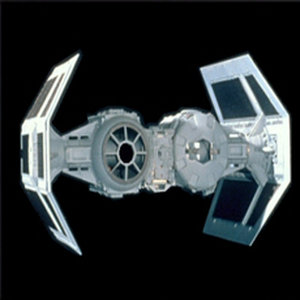

In [4]:
#@title Recuperar imágenes de las naves

#@markdown ### Parámetros de imágenes:
imagen_largo = 300 #@param {type:"integer"}
imagen_ancho = 300 #@param {type:"integer"}
imagen_color = True #@param {type:"boolean"}


#@markdown ### Recorte recuadro
recortar_recuadro = True #@param {type:"boolean"}
sacar_recuadro_superior = 35 #@param {type:"integer"}
sacar_recuadro_izquierdo = 20 #@param {type:"integer"}
sacar_recuadro_derecho = 50 #@param {type:"integer"}
sacar_recuadro_inferior = 55 #@param {type:"integer"}
recuperar_solo_una = False #@param {type:"boolean"}

# tamaño de las imágenes
if imagen_largo<=10:
  imagen_largo = 10
if imagen_ancho<=10:
  imagen_ancho = 10
IMAGE_SHAPE = (imagen_largo, imagen_ancho, (3 if imagen_color else 1))

if recortar_recuadro:
  IMAGE_CROP = (sacar_recuadro_izquierdo, sacar_recuadro_superior, imagen_ancho-sacar_recuadro_derecho, imagen_largo-sacar_recuadro_inferior)
else:
  IMAGE_CROP = None


# define tamaño de datos de entrada
num_inputs = IMAGE_SHAPE[0] * IMAGE_SHAPE[1] * IMAGE_SHAPE[2]

import requests # request img from web
import shutil # save img locally

# define función para cargar las imágenes
def cargarImagenes(navesList, IMAGE_CROP, procesa_solo_primera=False):
  classes_ori = []
  images_ori = []
  if IMAGE_SHAPE[2]==1:
    tipoImage = 'L'
  else:
    tipoImage = 'RGB'
  i = 0
  for nave in navesList:
        # obtiene datos de la imagen
        each_imagURL = nave[1]
        if each_imagURL != "":
          imagClass = nave[0]
          i = i + 1

          # baja la imagen
          URL_file_name = "./download_image_"+str(i)+".jpg"
          res = requests.get(each_imagURL, stream = True)
          if res.status_code == 200:
              with open(URL_file_name,'wb') as f:
                  shutil.copyfileobj(res.raw, f)
          else:
              print('No se puede descargar la imagen')

          # abre la imagen
          imag = Image.open(URL_file_name)

          # ajusta el tamaño
          imag = imag.convert(tipoImage)
          imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.LANCZOS)

          if IMAGE_CROP is not None:
            imag = imag.crop(IMAGE_CROP)
            imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.LANCZOS)

          # transforma a un vector de nros
          arImag = np.array(imag)

          # agrega a los vectores
          classes_ori.append( imagClass )
          images_ori.append( arImag )

          # si es la primera
          if procesa_solo_primera:
            break

  return classes_ori, images_ori, tipoImage

def mostrar_cant_por_clase(classList):
  aux = list(set(classList))
  print("- Cantidad por clase: ")
  for c in aux:
    print("\t " + str(c) + ": " + str(classList.count(c)))
  print("")

# carga las imagenes de entrenamiento
classes_ori, images_ori, tipoImage_ori = cargarImagenes(navesList, IMAGE_CROP, recuperar_solo_una)

print("")
print("- Clases cargadas: ", len(classes_ori))
print("- Imágenes cargadas: ", len(images_ori))
mostrar_cant_por_clase(classes_ori)


if len(images_ori)>0:
  print("- Ejemplo ", classes_ori[0], " ", images_ori[0].shape, ": ")
  display( Image.fromarray(images_ori[0], tipoImage_ori) )



(1)-  TIE Support Craft   (300, 300, 3) : 


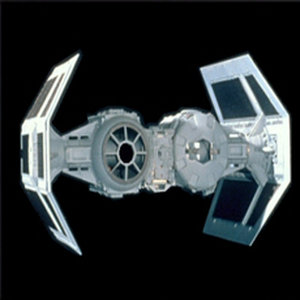


(2)-  TIE Experimental Craft   (300, 300, 3) : 


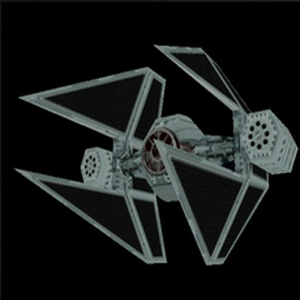


(3)-  Other Starfighters   (300, 300, 3) : 


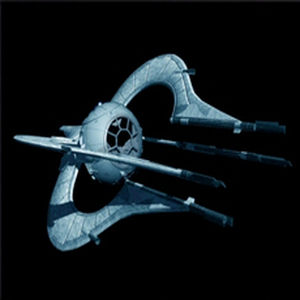


(4)-  Landing Craft   (300, 300, 3) : 


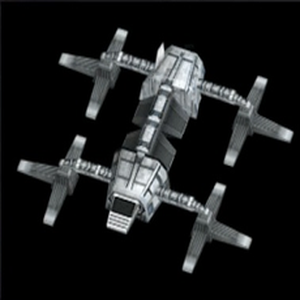


(5)-  Shuttles   (300, 300, 3) : 


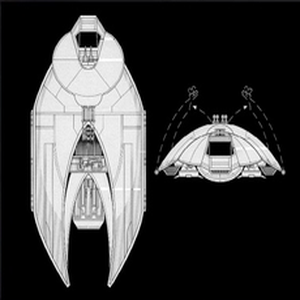


(6)-  Heavy Ships   (300, 300, 3) : 


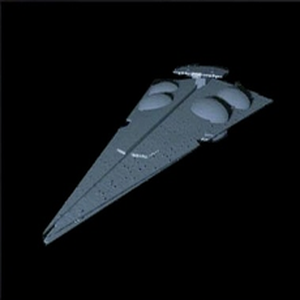


(7)-  TIE Fighters   (300, 300, 3) : 


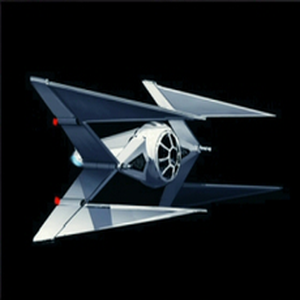


(8)-  TIE Fighters   (300, 300, 3) : 


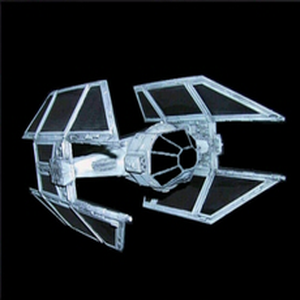


(9)-  TIE Fighters   (300, 300, 3) : 


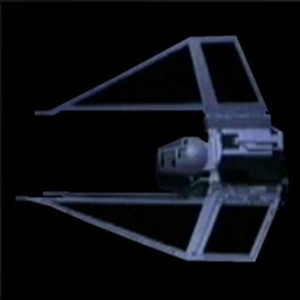


(10)-  Medium Ships   (300, 300, 3) : 


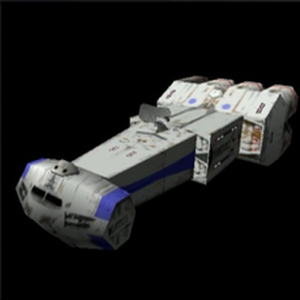


(11)-  Patrol Craft   (300, 300, 3) : 


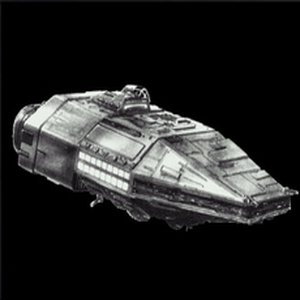


(12)-  Landing Craft   (300, 300, 3) : 


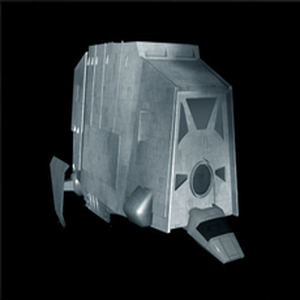


(13)-  Command Ships   (300, 300, 3) : 


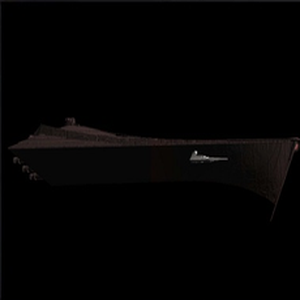


(14)-  Patrol Craft   (300, 300, 3) : 


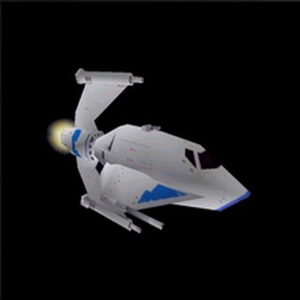


(15)-  TIE Experimental Craft   (300, 300, 3) : 


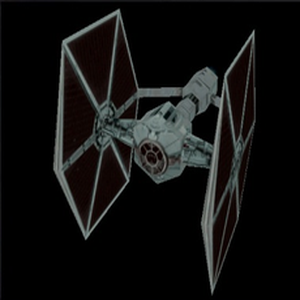


(16)-  Heavy Ships   (300, 300, 3) : 


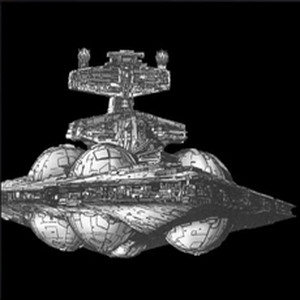


(17)-  TIE Support Craft   (300, 300, 3) : 


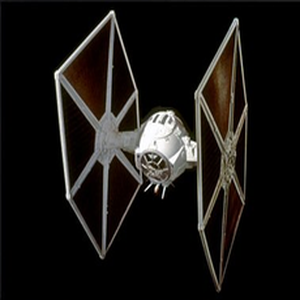


(18)-  TIE Fighters   (300, 300, 3) : 


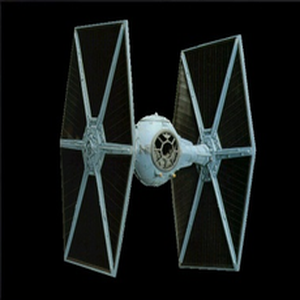


(19)-  TIE Fighters   (300, 300, 3) : 


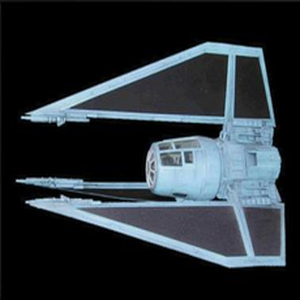


(20)-  TIE Bombers   (300, 300, 3) : 


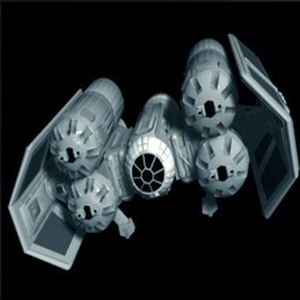


(21)-  Medium Ships   (300, 300, 3) : 


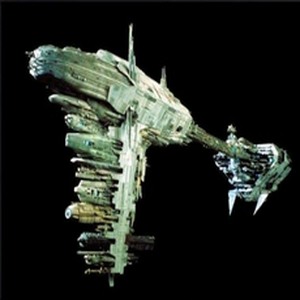


(22)-  TIE Support Craft   (300, 300, 3) : 


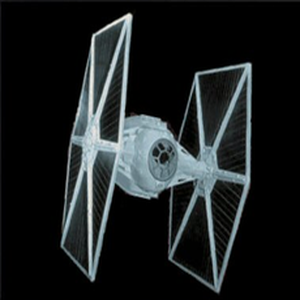


(23)-  Other Starfighters   (300, 300, 3) : 


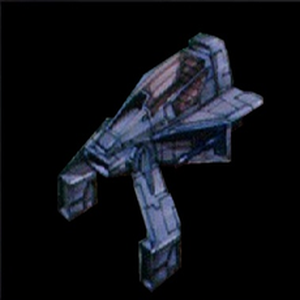


(24)-  Other Starfighters   (300, 300, 3) : 


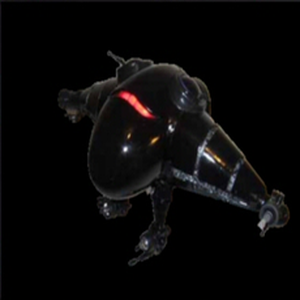


(25)-  Medium Ships   (300, 300, 3) : 


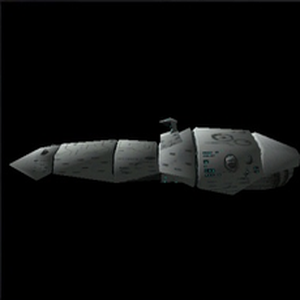

In [5]:
#@title Revisar imágenes descargadas

revisar_imagenes_cant = 25 #@param{type:"integer"}

for i in range(min(revisar_imagenes_cant, len(classes_ori))):
  print("\n("+str(i+1)+")- ", classes_ori[i], " ", images_ori[i].shape, ": ")
  display( Image.fromarray(images_ori[i], tipoImage_ori) )



#Aplicar Image Augmentation (opcional)

Ejemplo de posibles aplicaciones:


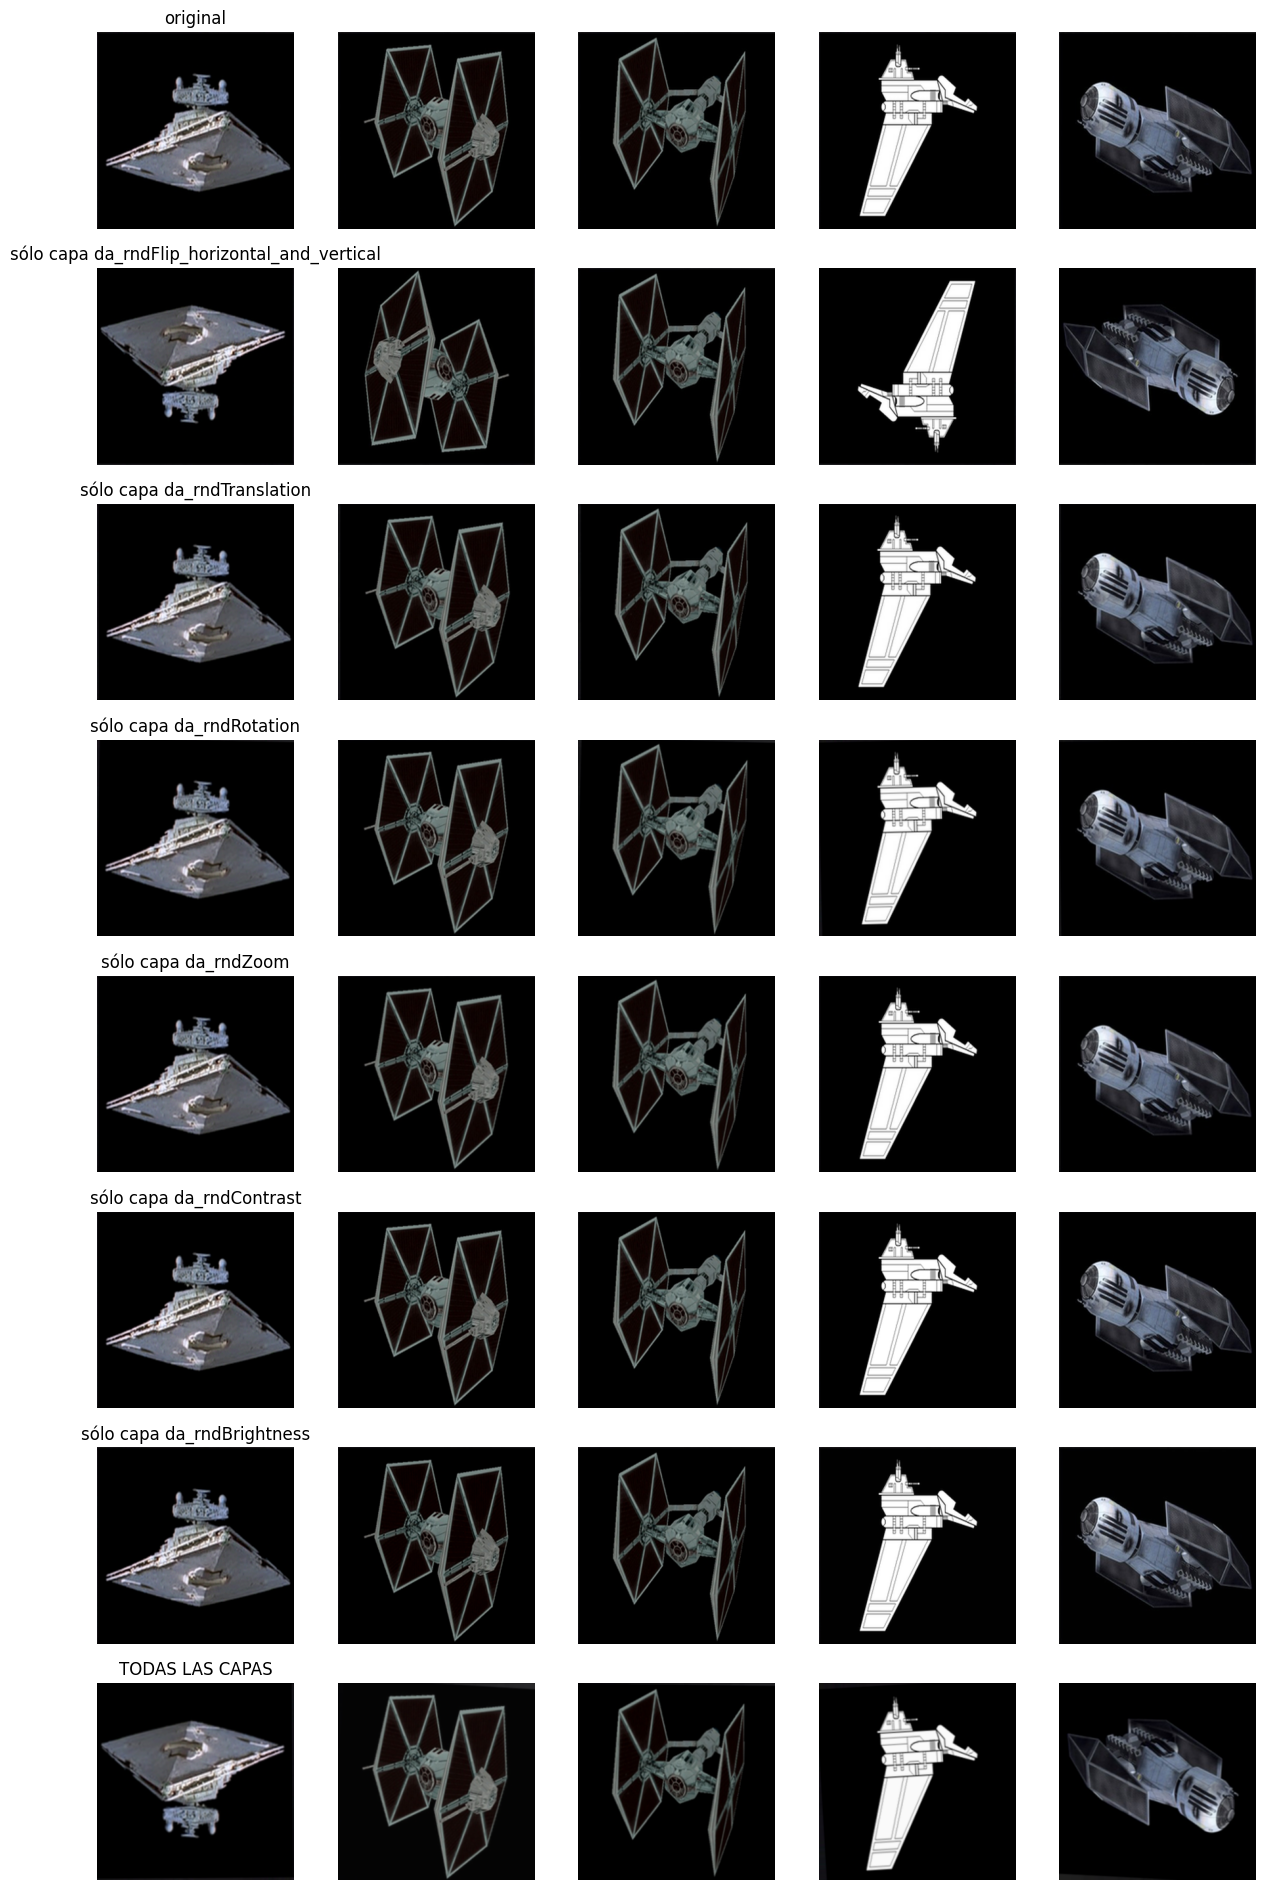

In [6]:
#@title Definición configuracón para Image Augmentation (opcional)

import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

aplicar_da_preProcesamiento = True #@param {type:"boolean"}

da_preProcesamiento_RandomFlip_Horizontal = True #@param {type:"boolean"}
da_preProcesamiento_RandomFlip_Vertical = True #@param {type:"boolean"}
da_preProcesamiento_RandomTranslation_Horizontal_factor = 0.01 #@param {type:"number"}
da_preProcesamiento_RandomTranslation_Vertical_factor = 0.01 #@param {type:"number"}
da_preProcesamiento_RandomRotation_factor = 0.01 #@param {type:"number"}
da_preProcesamiento_RandomZoom_factor = 0.01 #@param {type:"number"}
da_preProcesamiento_RandomContrast_factor = 0.02 #@param {type:"number"}
da_preProcesamiento_RandomBrightness_factor = 0.02 #@param {type:"number"}

daLayers_modelo = []

# capas de data augmentation (solo para training)
if aplicar_da_preProcesamiento:

  if da_preProcesamiento_RandomFlip_Horizontal or da_preProcesamiento_RandomFlip_Vertical:
    if da_preProcesamiento_RandomFlip_Horizontal:
      modeDAFlip = "horizontal"
      if da_preProcesamiento_RandomFlip_Vertical:
        modeDAFlip = modeDAFlip + "_and_vertical"
    else:
      modeDAFlip = "vertical"
    daLayers_modelo.append( tf.keras.layers.RandomFlip(mode=modeDAFlip, seed=None, name="da_rndFlip_"+modeDAFlip) )

  if (da_preProcesamiento_RandomTranslation_Horizontal_factor != 0.0) or (da_preProcesamiento_RandomTranslation_Vertical_factor != 0.0):
    daLayers_modelo.append( tf.keras.layers.RandomTranslation(height_factor=da_preProcesamiento_RandomTranslation_Vertical_factor/100, width_factor=da_preProcesamiento_RandomTranslation_Horizontal_factor, name="da_rndTranslation", fill_mode="nearest") )

  if da_preProcesamiento_RandomRotation_factor != 0.0:
      daLayers_modelo.append( tf.keras.layers.RandomRotation(factor=da_preProcesamiento_RandomRotation_factor, name="da_rndRotation", fill_mode="nearest") )

  if da_preProcesamiento_RandomZoom_factor != 0.0:
    daLayers_modelo.append( tf.keras.layers.RandomZoom(height_factor=da_preProcesamiento_RandomZoom_factor, name="da_rndZoom", fill_mode="nearest") )

  if da_preProcesamiento_RandomContrast_factor != 0.0:
    daLayers_modelo.append( tf.keras.layers.RandomContrast(factor=da_preProcesamiento_RandomContrast_factor, name="da_rndContrast") )

  if da_preProcesamiento_RandomBrightness_factor != 0.0:
    daLayers_modelo.append( tf.keras.layers.RandomBrightness(factor=da_preProcesamiento_RandomBrightness_factor, name="da_rndBrightness") )

# Visualize images and augmentations
cantCapasDA = len(daLayers_modelo) + 2
if cantCapasDA <= 2:
  print("No se aplican capas de Image Augmentation.")
else:
  print("Ejemplo de posibles aplicaciones:")
  fig, ax = plt.subplots(cantCapasDA, 5, figsize=(15,cantCapasDA*3))

  j = 0
  for j in range(5):

    # toma al azar las imágenes a mostrar
    posIm = random.randint(1, len(images_ori))
    im = images_ori[posIm-1]

    # muestra imagen original
    ax[0][j].imshow((im.astype("uint8")))
    if j == 0:
      ax[0][j].set_title("original")
    ax[0][j].axis('off')

    # muestra imagen con aplicación de capa
    i = 1
    for da_lay in daLayers_modelo:
            ax[i][j].imshow(da_lay( im/1.0 ).numpy().astype("uint8"))
            if j == 0:
              ax[i][j].set_title("sólo capa " + da_lay.name)
            ax[i][j].axis('off')
            i = i + 1

    # aplica todas las capas
    for da_lay in daLayers_modelo:
        im = da_lay(im)

    ax[i][j].imshow(im.numpy().astype("uint8"))
    if j == 0:
      ax[i][j].set_title("TODAS LAS CAPAS")
    ax[i][j].axis('off')

    j = j + 1

  plt.show()

In [7]:
#@title Generar imágenes con Image Augmentation (opcional)

cant_variaciones_generar_da_preProcesamiento = 30 #@param{type:"integer"}
intentar_balancear_clases = True #@param {type:"boolean"}

# inicializa variables
clases_newDA = []
images_newDA = []
cant = 0
cantTotal = 0

if aplicar_da_preProcesamiento and (cant_variaciones_generar_da_preProcesamiento>0):

  # inicializa cantidad por clase
  aux = list(set(classes_ori))
  cantGenerarClases = {}
  clMasImagenes = None
  clMasImagenes_cant = 0
  for cl in aux:
    cantActual = classes_ori.count(cl)
    cantGenerarClases[cl] = [cantActual, cantActual*cant_variaciones_generar_da_preProcesamiento, cant_variaciones_generar_da_preProcesamiento]
    # determina clase con más imágenes
    if (clMasImagenes is None) or (clMasImagenes_cant < cantActual):
      clMasImagenes = cl
      clMasImagenes_cant = cantActual


  # identifica maxima cantidad de imágenes a generar
  cantMaxGenerar = cantGenerarClases[clMasImagenes][0] + cantGenerarClases[clMasImagenes][1]

  print("- Cantidad a generar por clase: ")
  for cl in cantGenerarClases.keys():
    if intentar_balancear_clases:
      # determina cuántas imágenes se generan de la clase para intentar balancearlas
      cantGenerarClases[cl][1] = cantMaxGenerar - cantGenerarClases[cl][0]
      cantGenerarClases[cl][2] = (cantGenerarClases[cl][1]//cantGenerarClases[cl][0]) + 1
    cantTotal += cantGenerarClases[cl][1]
    print("\t " + ("*" if (clMasImagenes == cl) else "") + str(cl) + ": actual " + str(cantGenerarClases[cl][0]) + " + a generar " + str(cantGenerarClases[cl][1]) + " --> " + str(cantGenerarClases[cl][0]+cantGenerarClases[cl][1]) )
  print("")

  print("-- Comenzando a generar ", cantTotal," variaciones de imágenes...")
  for cl, im in zip(classes_ori, images_ori):
    for _ in range(cantGenerarClases[cl][2]):
      if (cantGenerarClases[cl][1]<=0):
        break
      # aplica todas las capas
      for da_lay in daLayers_modelo:
          im = da_lay(im)
      # agrega
      clases_newDA.append( cl )
      images_newDA.append( im.numpy().astype("uint8") )
      # contabiliza
      cant += 1
      cantGenerarClases[cl][1] -= 1
      if (cant % (cantTotal//20)) == 0:
        print("\t... ya se generaron ", cant, " imágenes...")

  print("\n > Se agregaron " + str(len(clases_newDA)) + " nuevas variaciones de las imágenes recolectadas.")
  print("- Cantidad a generar por clase: ")
  for cl in aux:
    print("\t " + str(cl) + ": " + str(clases_newDA.count(cl)))
  print("")

- Cantidad a generar por clase: 
	 Heavy Ships: actual 14 + a generar 606 --> 620
	 TIE Experimental Craft: actual 5 + a generar 615 --> 620
	 Medium Ships: actual 14 + a generar 606 --> 620
	 *TIE Fighters: actual 20 + a generar 600 --> 620
	 TIE Support Craft: actual 10 + a generar 610 --> 620
	 Patrol Craft: actual 5 + a generar 615 --> 620
	 Shuttles: actual 6 + a generar 614 --> 620
	 Command Ships: actual 3 + a generar 617 --> 620
	 Transporters: actual 4 + a generar 616 --> 620
	 Landing Craft: actual 7 + a generar 613 --> 620
	 TIE Bombers: actual 6 + a generar 614 --> 620
	 Other Starfighters: actual 10 + a generar 610 --> 620

-- Comenzando a generar  7336  variaciones de imágenes...
	... ya se generaron  366  imágenes...
	... ya se generaron  732  imágenes...
	... ya se generaron  1098  imágenes...
	... ya se generaron  1464  imágenes...
	... ya se generaron  1830  imágenes...
	... ya se generaron  2196  imágenes...
	... ya se generaron  2562  imágenes...
	... ya se generaro


(da_3690)-  TIE Bombers   (300, 300, 3) : 


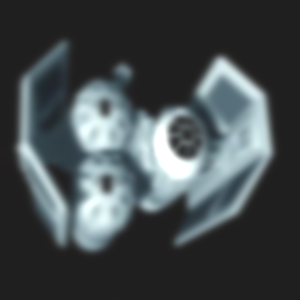


(da_2093)-  Medium Ships   (300, 300, 3) : 


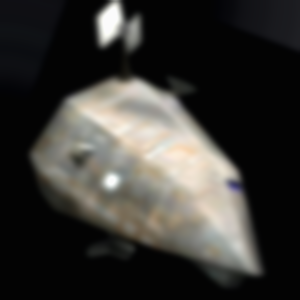


(da_4136)-  Patrol Craft   (300, 300, 3) : 


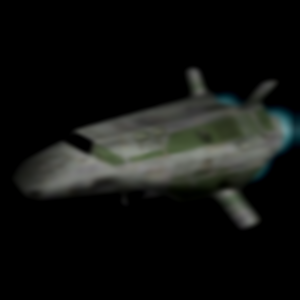


(da_5032)-  Landing Craft   (300, 300, 3) : 


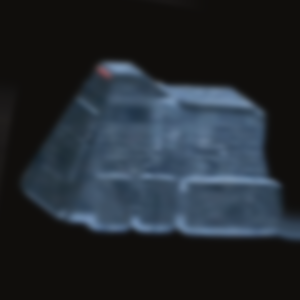


(da_1412)-  TIE Fighters   (300, 300, 3) : 


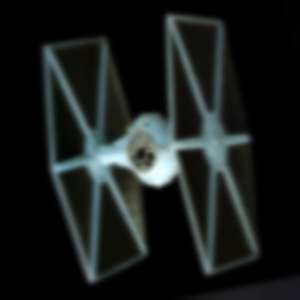


(da_4400)-  Medium Ships   (300, 300, 3) : 


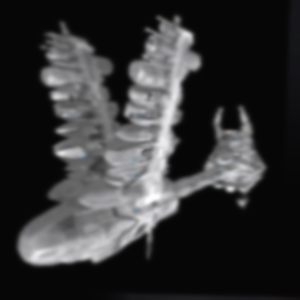


(da_498)-  TIE Fighters   (300, 300, 3) : 


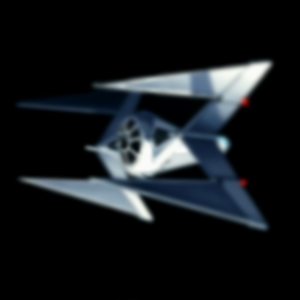


(da_3851)-  Heavy Ships   (300, 300, 3) : 


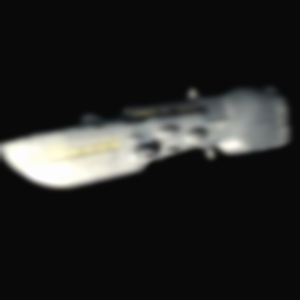


(da_1849)-  Heavy Ships   (300, 300, 3) : 


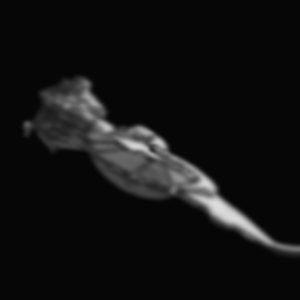


(da_6803)-  Other Starfighters   (300, 300, 3) : 


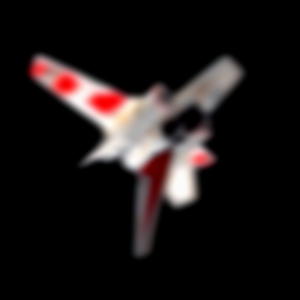


(da_2983)-  Transporters   (300, 300, 3) : 


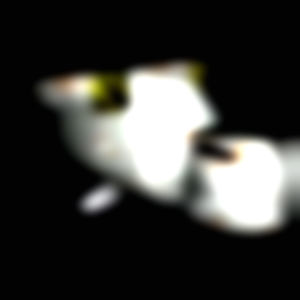


(da_4790)-  Command Ships   (300, 300, 3) : 


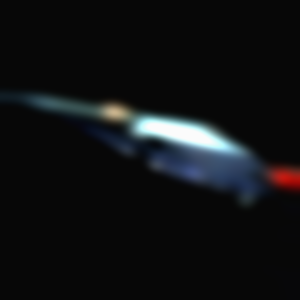


(da_69)-  TIE Experimental Craft   (300, 300, 3) : 


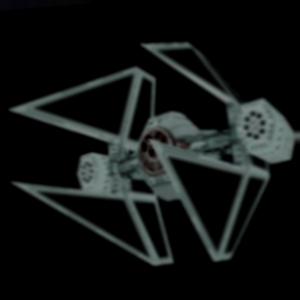


(da_5547)-  Shuttles   (300, 300, 3) : 


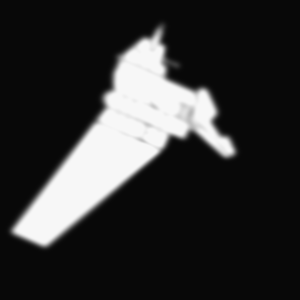


(da_5563)-  Shuttles   (300, 300, 3) : 


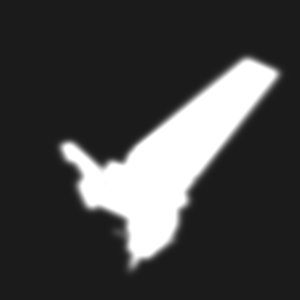


(da_7332)-  Medium Ships   (300, 300, 3) : 


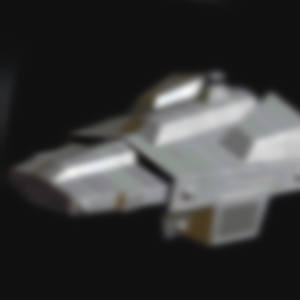


(da_3227)-  Shuttles   (300, 300, 3) : 


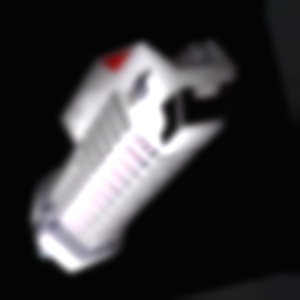


(da_6088)-  TIE Fighters   (300, 300, 3) : 


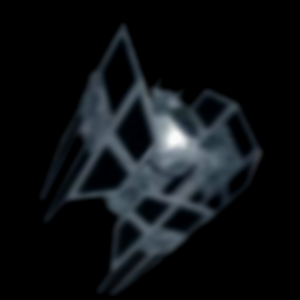


(da_3578)-  Heavy Ships   (300, 300, 3) : 


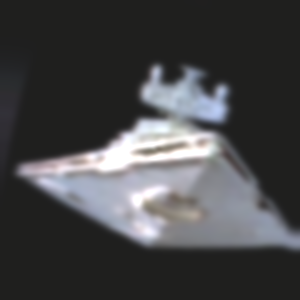


(da_6238)-  TIE Support Craft   (300, 300, 3) : 


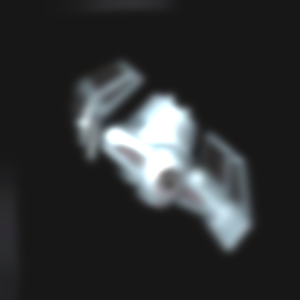

In [8]:
#@title Revisar imágenes generadas con Image Augmentation (orden al azar)

revisar_imagenes_da_cant = 20 #@param{type:"integer"}

for _ in range(min(revisar_imagenes_da_cant, len(clases_newDA))):
    i = random.randint(1, len(clases_newDA))
    print("\n(da_"+str(i+1)+")- ", clases_newDA[i], " ", images_newDA[i].shape, ": ")
    display( Image.fromarray(images_newDA[i], tipoImage_ori) )



#Divide en imágenes de Entrenamiento y Prueba

 Total de imágenes disponibles:  7440

> Para Entrenamiento: 
- Clases:  5952
- Imágenes:  5952
- Cantidad por clase: 
	 Heavy Ships: 496
	 TIE Experimental Craft: 496
	 Medium Ships: 496
	 TIE Fighters: 496
	 TIE Support Craft: 496
	 Patrol Craft: 496
	 Shuttles: 496
	 Command Ships: 496
	 Transporters: 496
	 Landing Craft: 496
	 TIE Bombers: 496
	 Other Starfighters: 496

- Ejemplo  Transporters   (300, 300, 3) : 


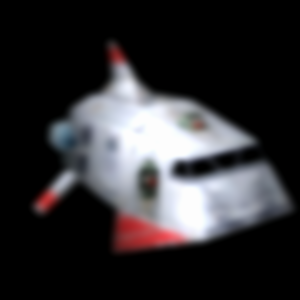



> Para Prueba: 
- Clases:  1488
- Imágenes:  1488
- Cantidad por clase: 
	 Heavy Ships: 124
	 TIE Experimental Craft: 124
	 Medium Ships: 124
	 TIE Fighters: 124
	 TIE Support Craft: 124
	 Patrol Craft: 124
	 Shuttles: 124
	 Other Starfighters: 124
	 Transporters: 124
	 Landing Craft: 124
	 TIE Bombers: 124
	 Command Ships: 124

- Ejemplo  Command Ships   (300, 300, 3) : 


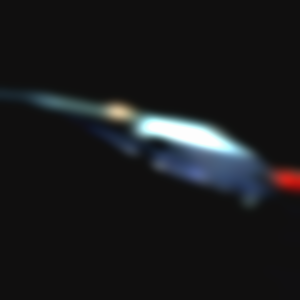

In [9]:
#@title Divide en imágenes para entrenamiento y para prueba

#@markdown ### Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   80#@param {type:"integer"}

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

# consolida las nuevas con las recolectadas
clases_dividir = []
clases_dividir.extend(classes_ori)
clases_dividir.extend(clases_newDA)
images_dividir = []
images_dividir.extend(images_ori)
images_dividir.extend(images_newDA)
print(" Total de imágenes disponibles: ", len(clases_dividir))
print("")

# divide en imaágenes de entrenamiento y prueba
images_train, images_test, classes_train, classes_test = train_test_split(images_dividir, clases_dividir, test_size=(1-propTrain), stratify=clases_dividir)
tipoImage_train = tipoImage_ori
tipoImage_test = tipoImage_ori

print("> Para Entrenamiento: ")
print("- Clases: ", len(classes_train))
print("- Imágenes: ", len(classes_train))
mostrar_cant_por_clase(classes_train)

if len(classes_train)>0:
  print("- Ejemplo ", classes_train[0], " ", images_train[0].shape, ": ")
  display( Image.fromarray(images_train[0], tipoImage_train) )

# carga las imagenes de prueba
print("\n\n> Para Prueba: ")
print("- Clases: ", len(classes_test))
print("- Imágenes: ", len(images_test))
mostrar_cant_por_clase(classes_test)

if len(classes_test)>0:
  print("- Ejemplo ", classes_test[0], " ", images_test[0].shape, ": ")
  display( Image.fromarray(images_test[0], tipoImage_test) )

In [11]:
#@title Grabar imágenes en Drive

import os
import uuid

# directorio local en Google Drive
exportar_imagenes = True  #@param {type:"boolean"}
path_imagenes = '/content/gdrive/MyDrive/IA/demoStarWars/imagenes/'  #@param {type:"string"}

def grabarImagenes(clasesList, imgList, dirPath):
  # crea directorio si no existe
  if not os.path.isdir(dirPath):
    os.mkdir(dirPath)
  # recorre los vectores y graba las imágenes
  cant = 0
  for c, i in zip(clasesList, imgList):
    pathClass = dirPath+c
    if not os.path.isdir(pathClass):
      os.mkdir(pathClass)
    imgFN = pathClass + "/" + str(uuid.uuid4().hex) + ".png"
    img = Image.fromarray(i, tipoImage_ori)
    img.save(imgFN)
    cant += 1
  print("\n> Se grabaron ", cant, "imágenes en ", dirPath)

if exportar_imagenes:
  # fuerza actualización del drive
  drive.flush_and_unmount()
  drive.mount('/content/gdrive')
  if os.path.isdir(path_imagenes):
    print("Ya existe el directorio ", path_imagenes, ": renombrelo o borrelo")
  else:
    os.mkdir(path_imagenes)
    # graba las imágenes de entrenamiento
    grabarImagenes(classes_train, images_train, path_imagenes+"train/")
    # graba las imágenes de prueba
    grabarImagenes(classes_test, images_test, path_imagenes+"test/")
    print("\nActualizando drive...")
    # fuerza actualización del drive
    drive.flush_and_unmount()
    drive.mount('/content/gdrive')
    print("\nDrive actualizado.")


Mounted at /content/gdrive

> Se grabaron  5952 imágenes en  /content/gdrive/MyDrive/IA/demoStarWars/imagenes/train/

> Se grabaron  1488 imágenes en  /content/gdrive/MyDrive/IA/demoStarWars/imagenes/test/

Actualizando drive...
Mounted at /content/gdrive

Drive actualizado.
